# Ternary plots for vanilla classifiers

In [1]:
import os
import sys
import time
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense

from utils.ops import onehot_encode
from utils.data import get_cifar3, get_cifarn
from utils.metrics import neg_log_likelihood, accuracy
from utils.visualization import plot_pdf_simplex, plot_prob_simplex
from calibrators import PAVCalibrator, NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline

## Load IRIS dataset

In [3]:
iris = load_iris()
ix2label = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'}

There are 50 samples per class, we can take 15 of each to form a validation set. Samples come ordered by class, the first 50 are class-0 samples, etc..

In [4]:
n_samples_class = 30

idxs0, idxs1, idxs2 = np.random.permutation(50), np.random.permutation(50)+50, np.random.permutation(50)+100

X_train = np.vstack((iris.data[idxs0[:n_samples_class], :],
                     iris.data[idxs1[:n_samples_class], :],
                     iris.data[idxs2[:n_samples_class], :]))
y_train = np.hstack((iris.target[idxs0[:n_samples_class]], iris.target[idxs1[:n_samples_class]], iris.target[idxs2[:n_samples_class]]))

X_test = np.vstack((iris.data[idxs0[n_samples_class:], :],
                    iris.data[idxs1[n_samples_class:], :],
                    iris.data[idxs2[n_samples_class:], :]))
y_test = np.hstack((iris.target[idxs0[n_samples_class:]], iris.target[idxs1[n_samples_class:]], iris.target[idxs2[n_samples_class:]]))

### Train a SVM

In [5]:
svc = SVC(kernel='rbf', probability=True);
svc.fit(X_train, y_train);

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [6]:
# Performance
print("Accuracy: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(svc.score(X_test, y_test)))

probs = svc.predict_proba(X_train)
probs_test = svc.predict_proba(X_test)
print("Cross-entropy: {:.3f}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {:.3f}".format(neg_log_likelihood(probs_test, y_test)))

Accuracy: 0.989
Accuracy on the test set: 0.933
Cross-entropy: 0.075
Cross-entropy on the test set: 0.164


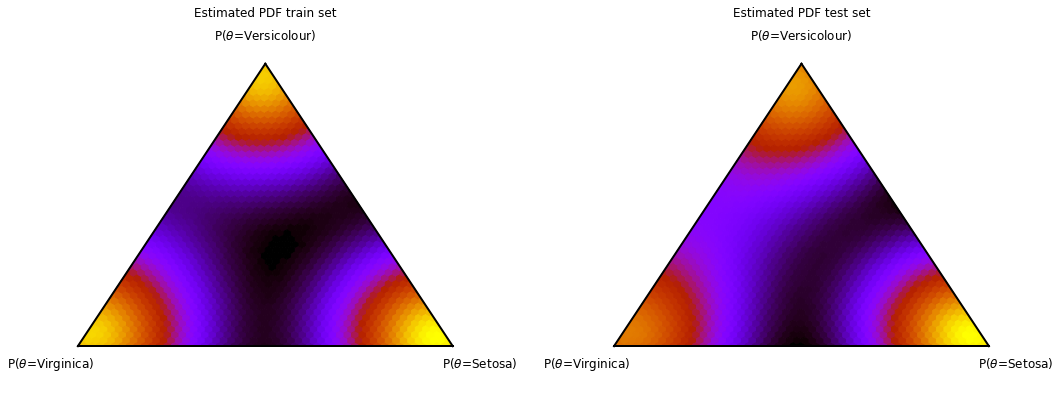

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(probs_test, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects 

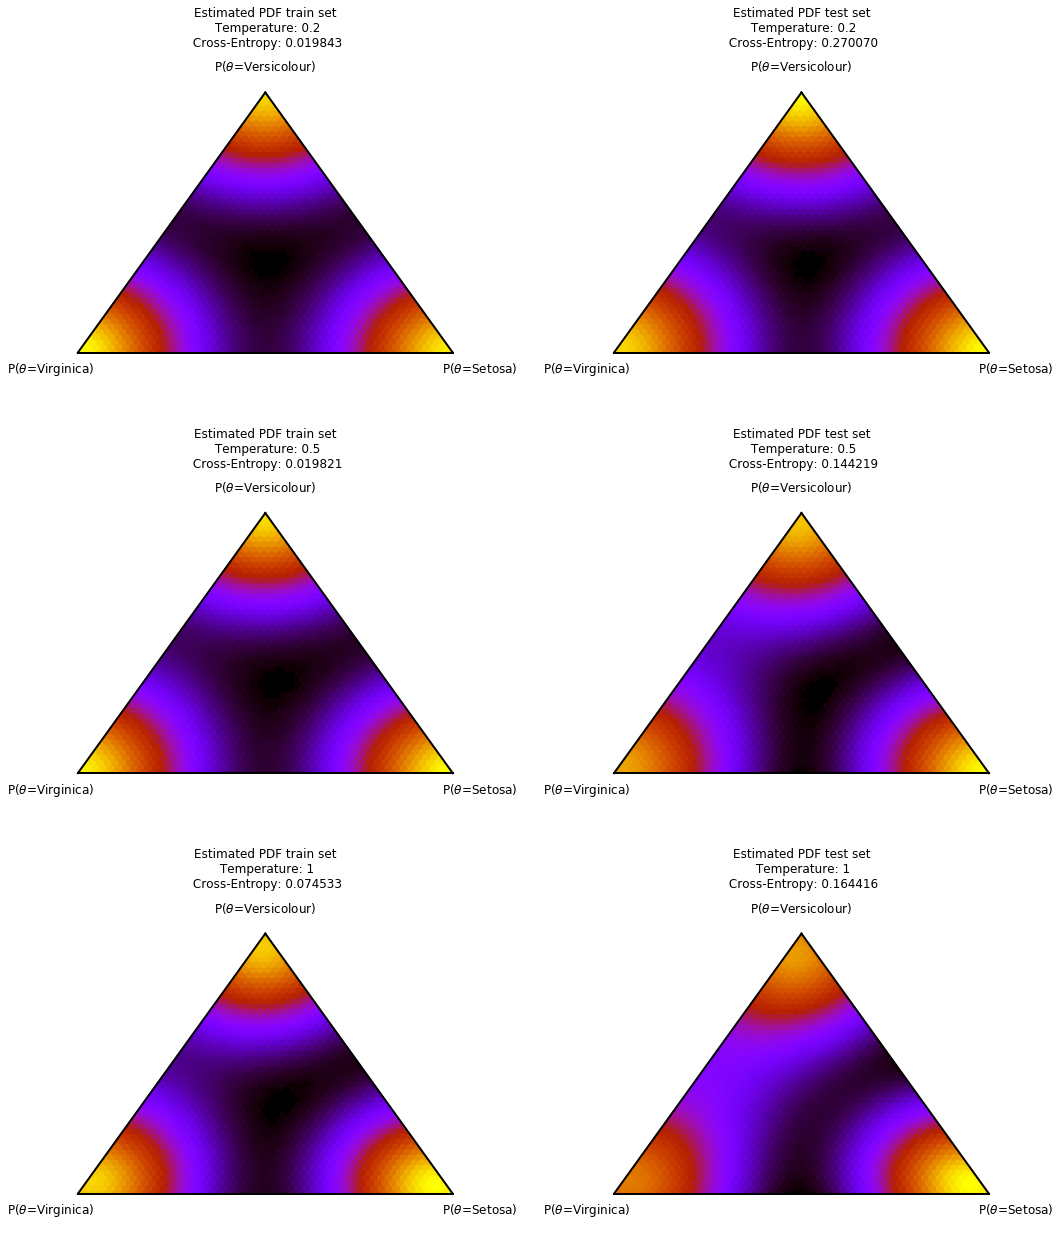

In [8]:
train_logits = svc.predict_log_proba(X_train)
test_logits = svc.predict_log_proba(X_test)

Ts = [0.2, 0.5, 1]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_simplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_simplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

### Optimum temperature

In [9]:
def optim_temperature(logits, target, min_diff=1e-5, step=0.1):
    T = 1.0
    probs = softmax(logits/T, axis=1)

    while True:
        # Compute gradient w.r.t. T
        one_hot = onehot_encode(target)
        grad = -np.mean(np.sum((probs-one_hot)*logits/T**2, axis=1))

        # Update step
        probs_new = softmax(logits/(T-grad*step), axis=1)

        if abs(grad*step) < min_diff:
            break

        T -= grad*step
        probs = probs_new

    return T

In [10]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.334
 achieves LNN=0.180 on test set
Optimum temperature for test set: 0.651
 achieves LNN=0.137 on test set


### Load CIFAR-3

In [11]:
data_path = '../cifar-10'
cifar3, ix2label = get_cifarn(data_path, target_labels=['airplane', 'automobile', 'bird'], test=True,
                              prior=[0.5, 0.2, 0.3], test_prior=[0.3, 0.5, 0.2])

### Train a simple classifier: PCA+Logistic

In [12]:
# Hyperparameters
n_components = 20

In [13]:
# Prepare data
y_train = cifar3['labels']
X_train = np.array([ima.flatten() for ima in cifar3['images']])

y_test = cifar3['test_labels']
X_test = np.array([ima.flatten() for ima in cifar3['test_images']])

In [14]:
# Fit PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
# Train LogisticRegression
t0 = time.time()
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 0.114s


In [16]:
# Train and test performance
print("Accuracy on the train set: {}".format(logistic.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(logistic.score(X_test_pca, y_test)))

probs = logistic.predict_proba(X_train_pca)
test_probs = logistic.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7026
Accuracy on the test set: 0.6245
Cross-entropy on the train set: 0.7354843970851581
Cross-entropy on the test set: 0.8794391714097985


## Visualizing results 

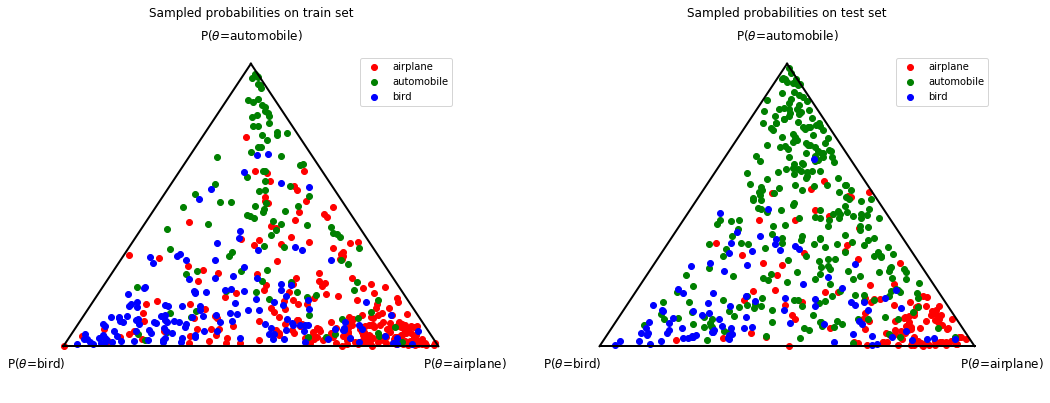

In [20]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_prob_simplex(probs[:500], target=y_train[:500], ax=ax_arr[0],
                              title='Sampled probabilities on train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_prob_simplex(test_probs[:500], target=y_test[:500], ax=ax_arr[1],
                              title='Sampled probabilities on test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

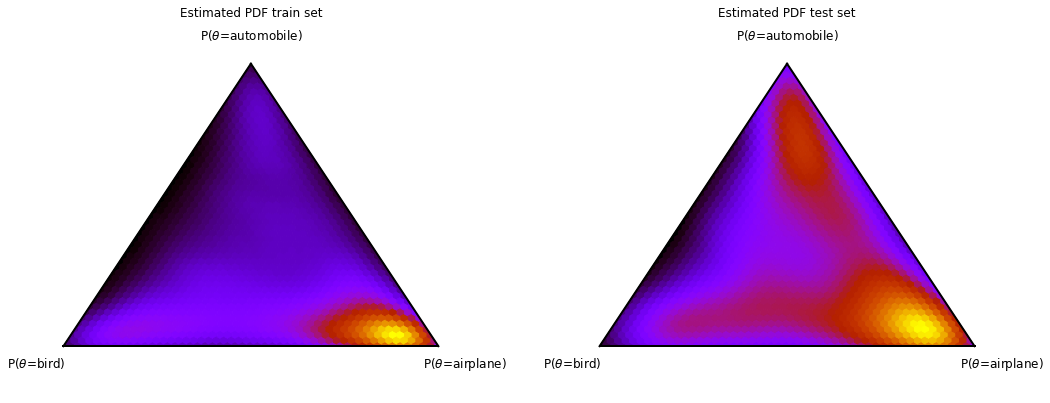

In [21]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects

In [22]:
train_logits = logistic.predict_log_proba(X_train_pca)
test_logits = logistic.predict_log_proba(X_test_pca)

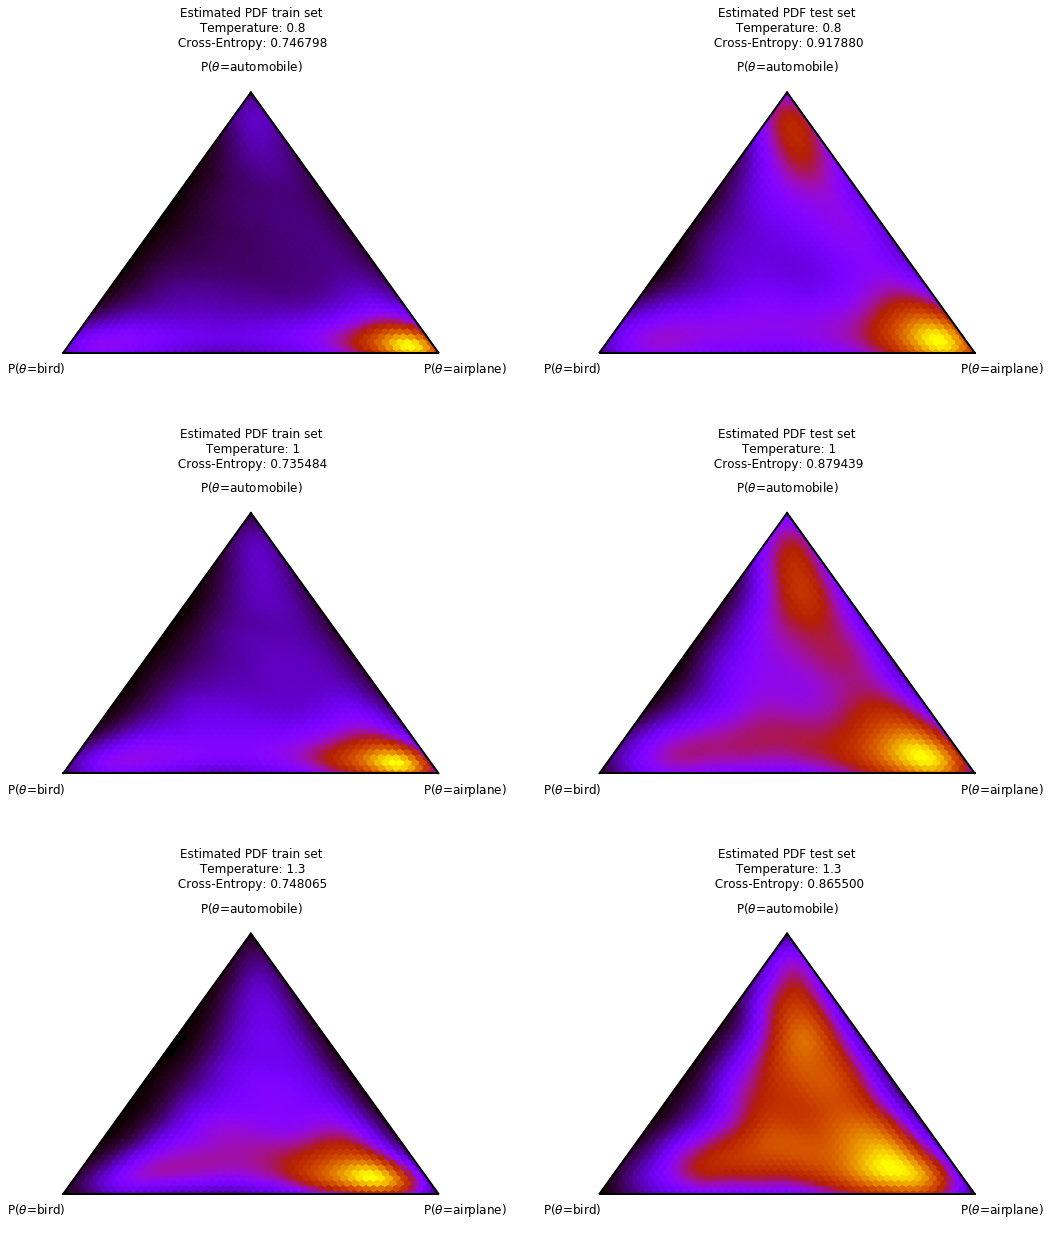

In [23]:
Ts = [0.8, 1, 1.3]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_simplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_simplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

In [24]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.999
 achieves LNN=0.879 on test set
Optimum temperature for test set: 1.311
 achieves LNN=0.865 on test set


## PCA + SVMLinear

In [25]:
# Train SVM
t0 = time.time()
svc = SVC(kernel='linear', probability=True);
svc.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 122.606s


In [26]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc.score(X_test_pca, y_test)))

probs = svc.predict_proba(X_train_pca)
test_probs = svc.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7086
Accuracy on the test set: 0.626
Cross-entropy on the train set: 0.734068267548816
Cross-entropy on the test set: 0.8785433522109577


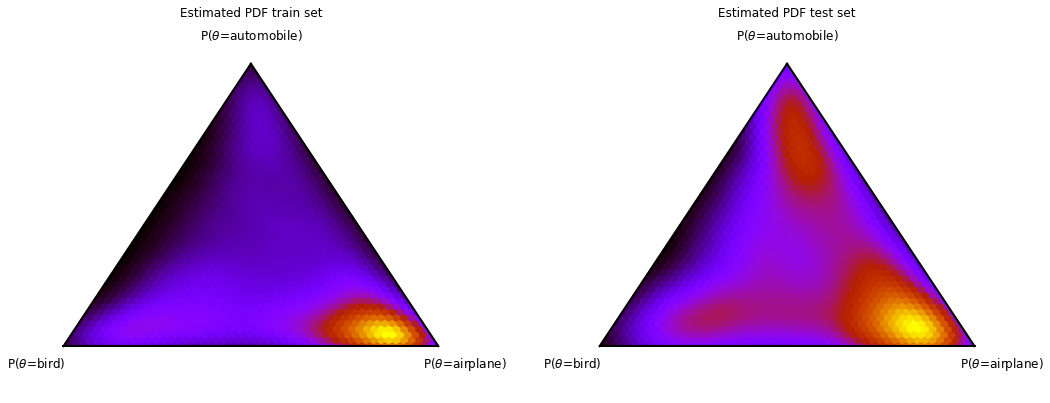

In [27]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [28]:
train_logits = svc.predict_log_proba(X_train_pca)
test_logits = svc.predict_log_proba(X_test_pca)

In [29]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.956
 achieves LNN=0.883 on test set
Optimum temperature for test set: 1.268
 achieves LNN=0.868 on test set


## PCA + SVMPolynomial

In [30]:
# Train SVM
t0 = time.time()
svc_poly = SVC(kernel='poly', degree=2, probability=True);
svc_poly.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 56.189s


In [31]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_poly.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_poly.score(X_test_pca, y_test)))

probs = svc_poly.predict_proba(X_train_pca)
test_probs = svc_poly.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7255
Accuracy on the test set: 0.6215
Cross-entropy on the train set: 0.6728020559211396
Cross-entropy on the test set: 0.8407276885863334


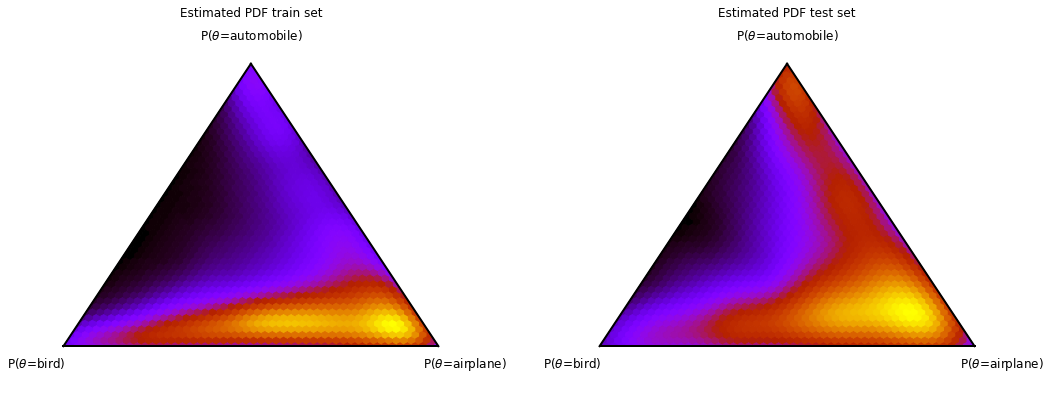

In [32]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [33]:
train_logits = svc_poly.predict_log_proba(X_train_pca)
test_logits = svc_poly.predict_log_proba(X_test_pca)

In [34]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.876
 achieves LNN=0.860 on test set
Optimum temperature for test set: 1.316
 achieves LNN=0.826 on test set


## PCA + SVMrbf 

In [35]:
# Train SVM
t0 = time.time()
svc_rbf = SVC(kernel='rbf', probability=True);
svc_rbf.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 57.724s


In [36]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_rbf.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_rbf.score(X_test_pca, y_test)))

probs = svc_rbf.predict_proba(X_train_pca)
test_probs = svc_rbf.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8626
Accuracy on the test set: 0.7465
Cross-entropy on the train set: 0.38057168888398457
Cross-entropy on the test set: 0.6018983150664724


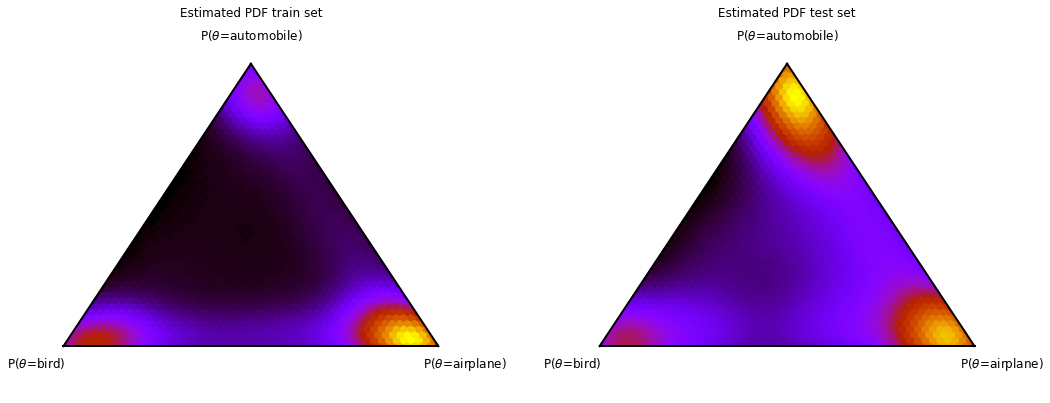

In [37]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [38]:
train_logits = svc_rbf.predict_log_proba(X_train_pca)
test_logits = svc_rbf.predict_log_proba(X_test_pca)

In [39]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.786
 achieves LNN=0.632 on test set
Optimum temperature for test set: 1.124
 achieves LNN=0.599 on test set


# SmallCNN

In [37]:
cnn_path = '../pretrained-models/cnn_cifar'

In [38]:
model = tf.keras.models.load_model(os.path.join(cnn_path, 'cnn_cifar.h5'), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [39]:
# Compute predictions
train_probs = model.predict(cifar3['images']/255.)
test_probs = model.predict(cifar3['test_images']/255.)

In [40]:
# Train and test performance
print("Accuracy on the train set: {}".format(accuracy(train_probs, y_train)))
print("Accuracy on the test set: {}".format(accuracy(test_probs, y_test)))


print("Cross-entropy on the train set: {}".format(neg_log_likelihood(train_probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8674
Accuracy on the test set: 0.8595
Cross-entropy on the train set: 0.35230136537863693
Cross-entropy on the test set: 0.3548127238333036


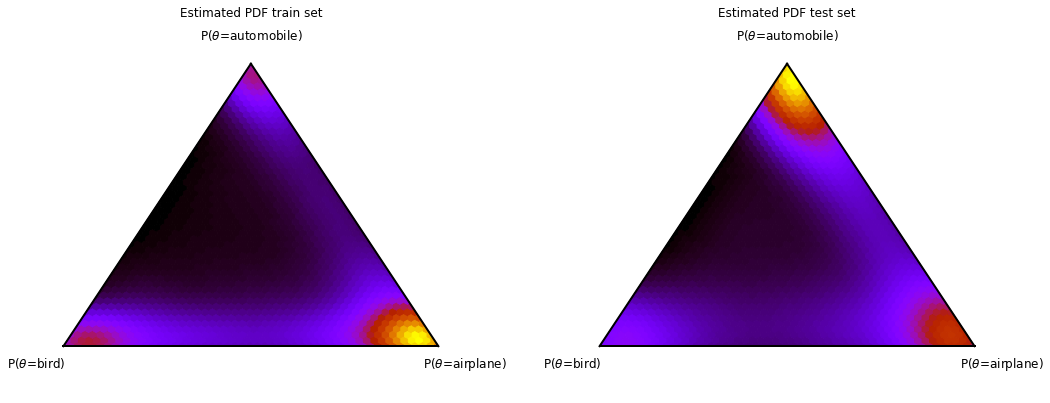

In [41]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(train_probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

## Calibrating cnn
### Obtain the logits

In [42]:
logits = np.log(model.predict(cifar3['test_images']/255.).astype(np.float))
target = onehot_encode(y_test.astype(np.int))

### Temperature Scaling 

In [43]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, target)
temp_acc = accuracy(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 0.822, elapsed time: 0.100s
Negative log-likelihood after calibration with temp-scaling: 0.348
Accuracy after calibration with temp-scaling: 0.860


Effect on simplex:

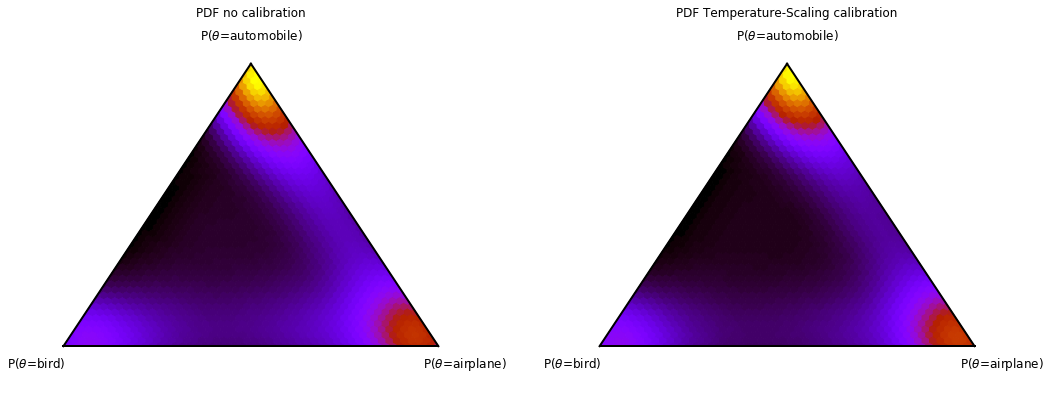

In [44]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(temp_probs, ax=ax_arr[1], title='PDF Temperature-Scaling calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### PAV calibration 

In [45]:
t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.006s


In [46]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(pav_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with temp-scaling: 0.297
Accuracy after calibration with temp-scaling: 0.875


Effects on probability simplex:

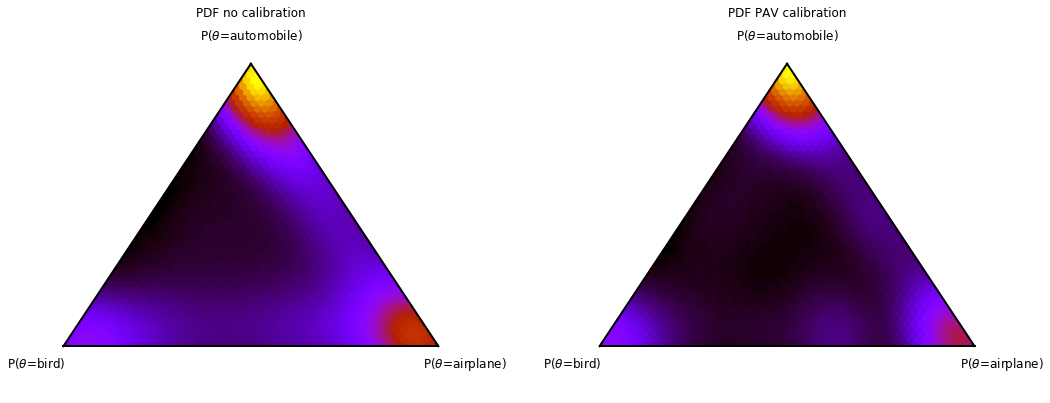

In [47]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(pav_probs, ax=ax_arr[1], title='PDF PAV calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### NICE calibration

In [48]:
t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4,
                          hidden_size=[6, 6, 6], epochs=1000, batch_size=100)
print("NICE-flow calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow calibration fitted, elapsed time: 116.214s


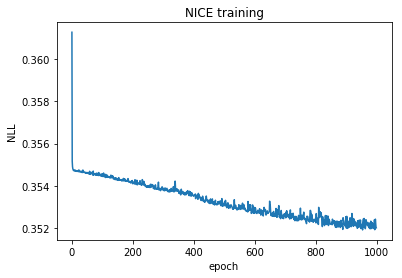

In [49]:
# Visalize training
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE training')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.show()

In [50]:
nice_probs = nice_cal.predict(logits)

nll_nice = neg_log_likelihood(nice_probs, y_test)
nice_acc = accuracy(nice_probs, y_test)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))
print("Accuracy after calibration with NICE: {:.3f}".format(nice_acc))

Negative log-likelihood after calibration with NICE: 0.352
Accuracy after calibration with NICE: 0.860


Effects on probability simplex:

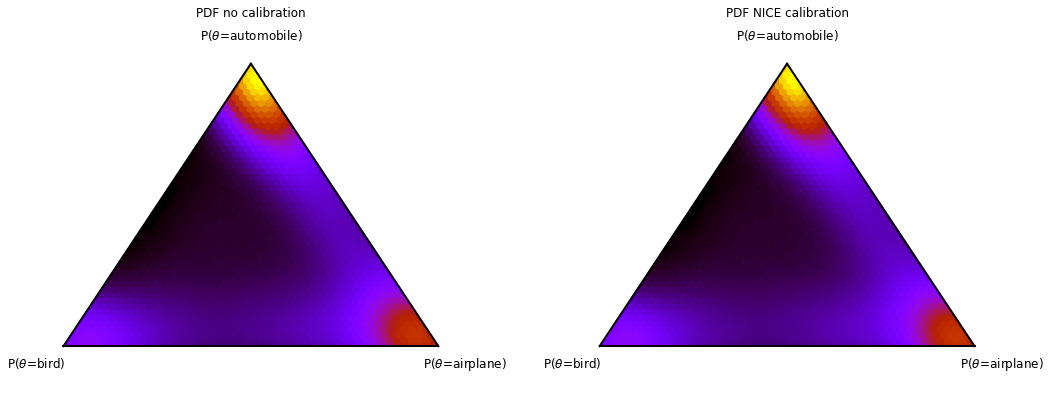

In [51]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(nice_probs, ax=ax_arr[1], title='PDF NICE calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()